<a href="https://colab.research.google.com/github/SusmitWani/NNFL-Course-Fall-2020/blob/master/K_means_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
"""Most of the code provided below has been taken from the following github repository:
https://github.com/tugot17/K-Means-Algorithm-From-Scratch
with modifications to generate initial centroids, and re-written code for get_euclidean_distance and final part of code for comparing time complexity against number of clusters
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import random
import time

Setting Seeds

In [2]:
random.seed(5)
np.random.seed(5)

Generating random centroids

In [3]:
def get_initial_centroids(X, k):
    """
    Function picks k random data points from dataset X, recurring points are removed and replaced but new points
    so a result we have array of k unique points. Founded points can be used as intial centroids for k means algorithm
    Args:
        X (numpy.ndarray) : dataset points array, size N:D
        k (int): number of centroids

    Returns:
        (numpy.ndarray): array of k unique initial centroids, size K:D

    """
    number_of_samples = X.shape[0]
    sample_points_ids = random.sample(range(0, number_of_samples), k)

    centroids = [tuple(X[id]) for id in sample_points_ids]
    unique_centroids = list(set(centroids))

    number_of_unique_centroids = len(unique_centroids)

    while number_of_unique_centroids < k:
        new_sample_points_ids = random.sample(range(0, number_of_samples), k - number_of_unique_centroids)
        new_centroids = [tuple(X[id]) for id in new_sample_points_ids]
        unique_centroids = list(set(unique_centroids + new_centroids))

        number_of_unique_centroids = len(unique_centroids)

    return np.array(unique_centroids)

Euclidean Distance is calculated using the following formula
: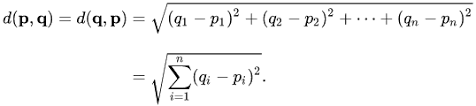

In [4]:
def get_euclidean_distance(A_matrix, B_matrix):
    """
    Function computes euclidean distance between matrix A and B.
    E. g. C[2,15] is distance between point 2 from A (A[2]) matrix and point 15 from matrix B (B[15])
    Args:
        A_matrix (numpy.ndarray): Matrix size N1:D
        B_matrix (numpy.ndarray): Matrix size N2:D

    Returns:
        numpy.ndarray: Matrix size N1:N2
    """

    C = np.empty([A_matrix.shape[0], B_matrix.shape[0]])
    for i in range(A_matrix.shape[0]):
        for j in range(B_matrix.shape[0]):
            C[i][j] = np.sum((A_matrix[i] - B_matrix[j])**2)
    return np.sqrt(C)
    ############################################################ (Nilesh)

In [5]:
def get_clusters(X, centroids, distance_mesuring_method):
    """
    Function finds k centroids and assigns each of the N points of array X to one centroid
    Args:
        X (numpy.ndarray): array of sample points, size N:D
        centroids (numpy.ndarray): array of centroids, size K:D
        distance_mesuring_method (function): function taking 2 Matrices A (N1:D) and B (N2:D) and returning distance
        between all points from matrix A and all points from matrix B, size N1:N2

    Returns:
        dict {cluster_number: list_of_points_in_cluster}
    """

    k = centroids.shape[0]

    clusters = {}

    distance_matrix = distance_mesuring_method(X, centroids)
    closest_cluster_ids = np.argmin(distance_matrix, axis=1)

    for i in range(k):
        clusters[i] = []

    for i, cluster_id in enumerate(closest_cluster_ids):
        clusters[cluster_id].append(X[i])

    return clusters
    ####################################### (Amit)

Generation of n centroid lists and choosing the one with the minimum variance

In [6]:
def choosing_initial_centroids(k, n, X, distance_mesuring_method):
    """
    Function randomizes n sets of initial centroids and chooses the list with the minimum variance
    Args:
        k (int): number of centroids/clusters
        n (int): number of initial lists to be generated
        X (numpy.ndarray): array of sample points, size N:D
        distance_mesuring_method (function): function taking 2 Matrices A (N1:D) and B (N2:D) and returning distance
        between all points from matrix A and all points from matrix B, size N1:N2

    Returns:
        list {centroids_list[i] : the set of centroids with the minimum variance}
    """
    dimensions = [n]
    dimensions.append(k)
    dimensions.append(X.shape[1])
    centroids_list = np.empty(dimensions)
    cluster_list = []
    for i in range(n):
        centroids_list[i] = get_initial_centroids(X, k)
        cluster_list.append([])
    for i in range(n):
        cluster_list[i] = get_clusters(X, centroids_list[i], distance_mesuring_method)
    
    min_var = []
    for i in range(n):
        sum = 0
        for j in cluster_list[i]:
            for k in cluster_list[i][j]:
                sum += np.sum((j - k)**2)
        min_var.append(sum)
    min_var_centroids = 0
    for i in range(n):
        if(min_var[i] < min_var[min_var_centroids]):
            min_var_centroids = i
    return centroids_list[i]
    #################################################### (Vinayak)

Code to check if the centroids moved at least by the threshold or not

In [7]:
def has_centroids_covered(previous_centroids, new_centroids, distance_mesuring_method, movement_threshold_delta):
    """
    Function checks if any of centroids moved more then MOVEMENT_THRESHOLD_DELTA if not we assume the centroids were founded
    Args:
        previous_centroids (numpy.ndarray): array of k old centroids, size K:D
        new_centroids (numpy.ndarray): array of k new centroids, size K:D
        distance_mesuring_method (function): function taking 2 Matrices A (N1:D) and B (N2:D) and returning distance
        movement_threshold_delta (float): threshold value, if centroids move less we assume that algorithm covered


    Returns: boolean True if centroids coverd False if not

    """
    distances_between_old_and_new_centroids = distance_mesuring_method(previous_centroids, new_centroids)
    centroids_covered = np.max(distances_between_old_and_new_centroids.diagonal()) <= movement_threshold_delta

    return centroids_covered
    ############################### (Avdhoot)

Combining all the helper functions to perform k-means clustering on a dataset

In [8]:
def perform_k_means_algorithm(X, initial_centroid_nums, k, distance_mesuring_method, movement_threshold_delta=0):
    """
    Function performs k-means algorithm on a given dataset, finds and returns k centroids
    Args:
        X (numpy.ndarray) : dataset points array, size N:D
        distance_mesuring_method (function): function taking 2 Matrices A (N1:D) and B (N2:D) and returning distance
        between all points from matrix A and all points from matrix B, size N1:N2.
        k (int): number of centroids
        movement_threshold_delta (float): threshold value, if centroids move less we assume that algorithm covered

    Returns:
        (numpy.ndarray): array of k centroids, size K:D
    """

    new_centroids = choosing_initial_centroids(k, 100, X, distance_mesuring_method)

    centroids_covered = False
    epochs = 0
    print("Original Estimates")
    
        
    while not centroids_covered:
        epochs = epochs+1
        previous_centroids = new_centroids
        clusters = get_clusters(X, previous_centroids, distance_mesuring_method)
        if(epochs == 1):
          #Plotting the original dataset with original estimation of centroids
            for centroid, points in clusters.items():
                points = np.array(points)
                centroid = np.mean(points, axis=0)
                plt.scatter(points[:, 0], points[:, 1], marker='o')
                plt.grid()
                plt.scatter(centroid[0], centroid[1], marker='x', color="red")
            plt.show()
        new_centroids = np.array([np.mean(clusters[key], axis=0, dtype=X.dtype) for key in sorted(clusters.keys())])

        centroids_covered = has_centroids_covered(previous_centroids, new_centroids, distance_mesuring_method, movement_threshold_delta)
    print("Number of epochs trained: ", epochs)
    return new_centroids
    ###################### (Siddharth)

Performing the algorithm on a dataset of 6 clusters


Original Estimates


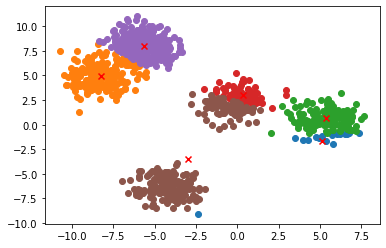

Number of epochs trained:  6
Final Estimates


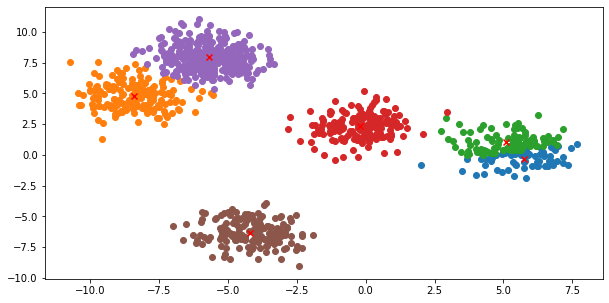

In [9]:
k = 6
n = 10
#Using make_blobs to create a dataset for clustering using k-means
X, _ = make_blobs(n_samples=1000, n_features=2, centers=k)
#Creating a list of end_times for different values of k
centroids = perform_k_means_algorithm(X, n, k, movement_threshold_delta=1/10, distance_mesuring_method=get_euclidean_distance)
#Getting the clusters for plotting the graph
clusters = get_clusters(X, centroids, get_euclidean_distance)
#Plotting of Final Clusters and Centroids
plt.rcParams['figure.figsize'] = [10, 5]
print("Final Estimates")
for centroid, points in clusters.items():
    points = np.array(points)
    centroid = np.mean(points, axis=0)
    plt.scatter(points[:, 0], points[:, 1], marker='o')
    plt.grid()
    plt.scatter(centroid[0], centroid[1], marker='x', color="red")
plt.show()


Comparing time complexity with number of clusters

Original Estimates


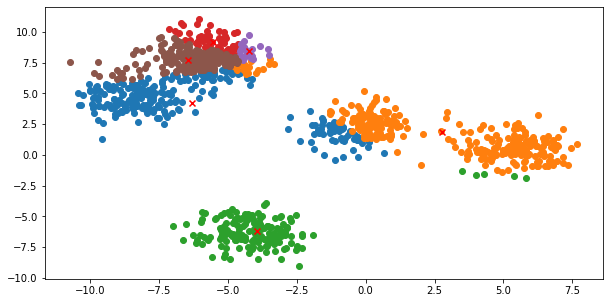

Number of epochs trained:  5
Final Estimates


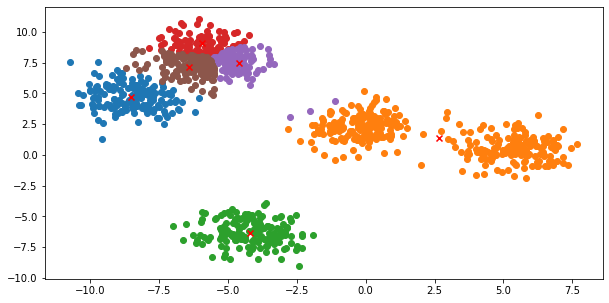

Original Estimates


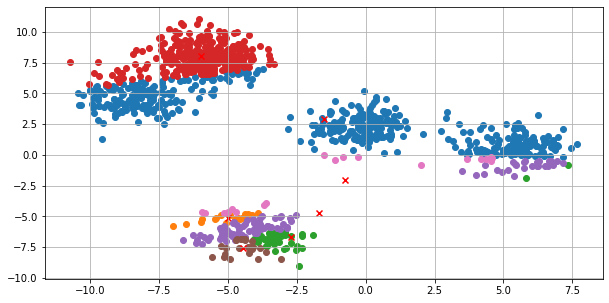

Number of epochs trained:  7
Final Estimates


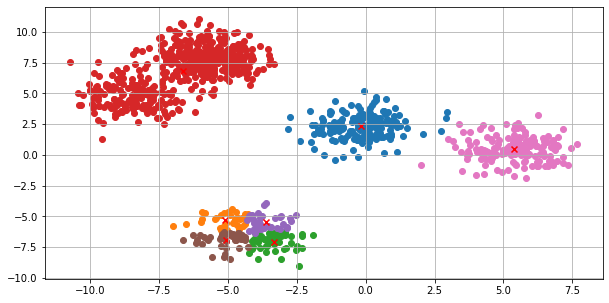

Original Estimates


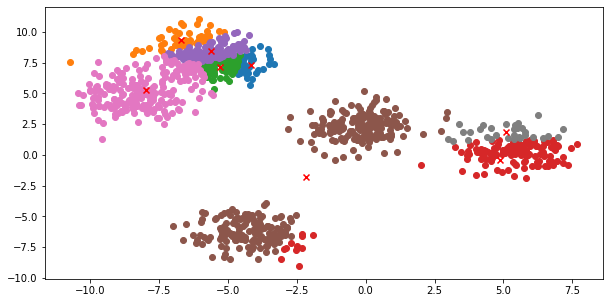

Number of epochs trained:  7
Final Estimates


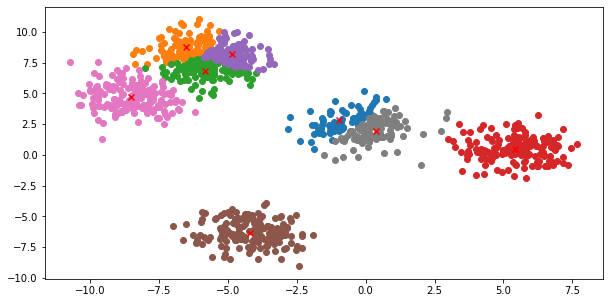

Original Estimates


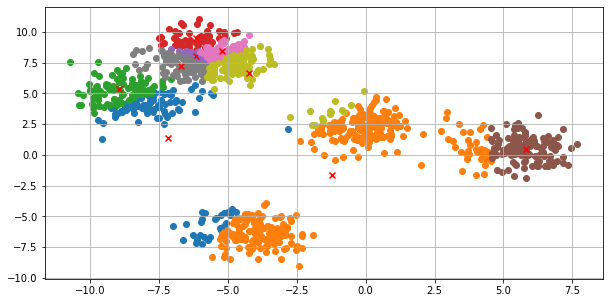

Number of epochs trained:  7
Final Estimates


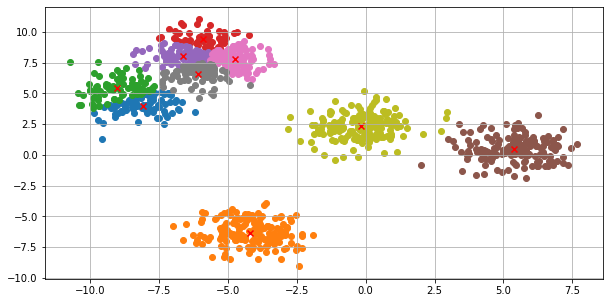

Original Estimates


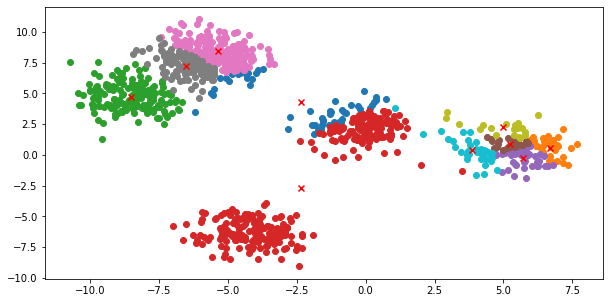

Number of epochs trained:  5
Final Estimates


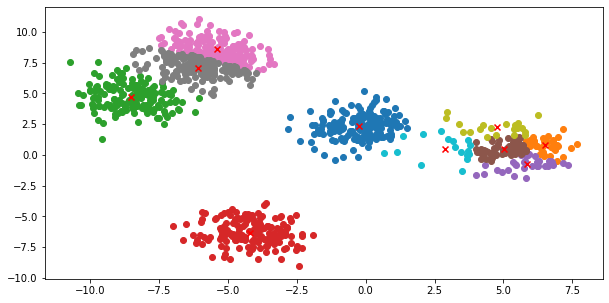

Original Estimates


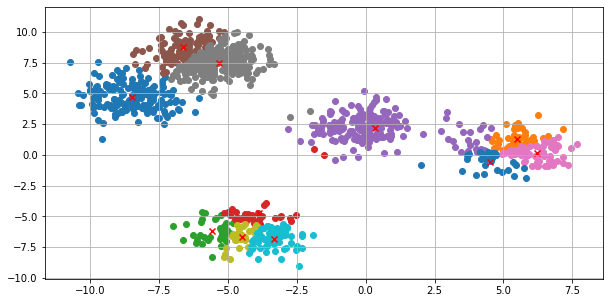

Number of epochs trained:  5
Final Estimates


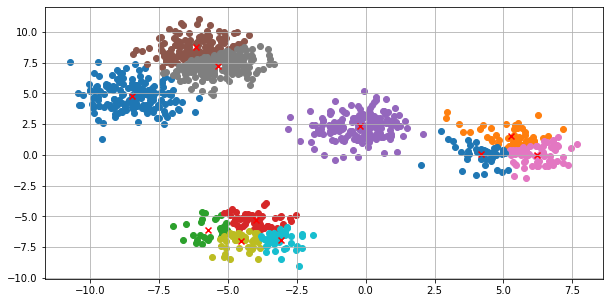

Original Estimates


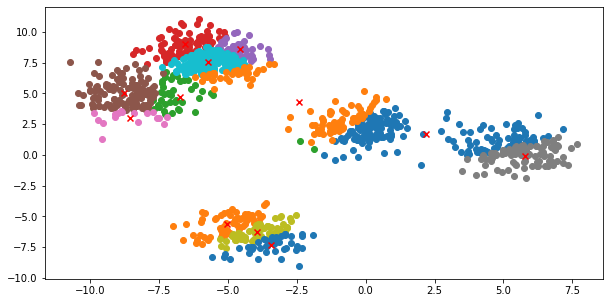

Number of epochs trained:  6
Final Estimates


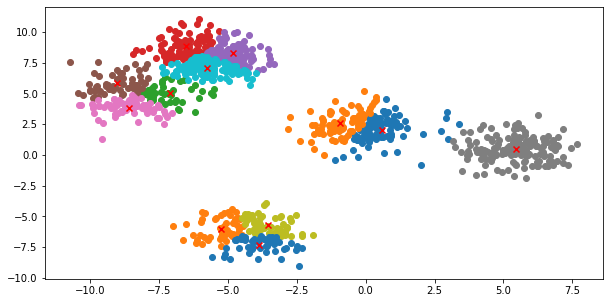

[5.326637029647827, 6.257091999053955, 6.940820693969727, 7.694756031036377, 8.282260417938232, 8.972889423370361, 9.75667929649353]


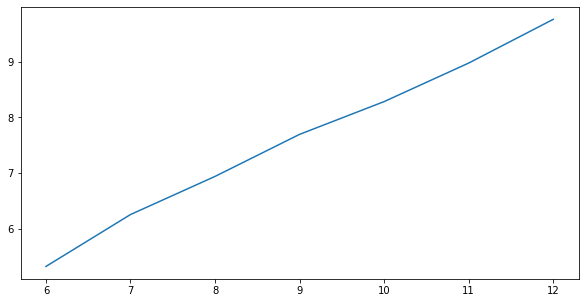

In [10]:
end_times = []
for k in range(6, 13):
    start_time = time.time()
    centroids = perform_k_means_algorithm(X, n, k, movement_threshold_delta=1/10, distance_mesuring_method=get_euclidean_distance)
    end_time = time.time()
    end_times.append(end_time - start_time)
    #Getting the clusters for plotting the graph
    clusters = get_clusters(X, centroids, get_euclidean_distance)
    #Plotting of Final Clusters and Centroids
    plt.rcParams['figure.figsize'] = [10, 5]
    print("Final Estimates")
    for centroid, points in clusters.items():
        points = np.array(points)
        centroid = np.mean(points, axis=0)
        plt.scatter(points[:, 0], points[:, 1], marker='o')
        plt.grid()
        plt.scatter(centroid[0], centroid[1], marker='x', color="red")
    plt.show()
print(end_times)
plt.plot(range(6, 13), end_times)
###################### (Susmit)